In [ ]:
import numpy as np
import pandas as pd
import os
import re
import random

!pip install emot
!pip install emoji

import emoji

!pip install keras
!pip install tensorflow
!pip install plot_keras_history
!pip install seaborn

from keras.utils import np_utils
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.layers import InputLayer, Activation, merge, Concatenate,Input
import keras.backend as K
from keras.models import Sequential
from keras.layers.embeddings import Embedding

from keras.layers import Dense, Embedding, Lambda, Reshape
from keras.layers import Input
from keras.models import Model
from keras.layers import dot
from tensorflow.keras.activations import relu
from nltk import word_tokenize, sent_tokenize
from gensim.corpora.dictionary import Dictionary
import numpy as np

from keras.preprocessing.sequence import skipgrams
import gensim

# using nltk tokenizer.  
import nltk
nltk.download('punkt')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks_2/Practice module')

Mounted at /content/gdrive


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


# Load Data

In [4]:
raw_tweets = pd.read_csv('tweets_output_generic_clean.csv')
raw_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5755 entries, 0 to 5754
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             5755 non-null   int64 
 1   Unnamed: 0.1           5755 non-null   int64 
 2   text                   5755 non-null   object
 3   username               5755 non-null   object
 4   favourite_count        5755 non-null   int64 
 5   retweet_count          5755 non-null   int64 
 6   created_at             5755 non-null   object
 7   place                  45 non-null     object
 8   text_without_URLS      5755 non-null   object
 9   text_without_mentions  5755 non-null   object
 10  sentiments             3899 non-null   object
 11  Unnamed: 11            43 non-null     object
dtypes: int64(4), object(8)
memory usage: 539.7+ KB


# Preprocessing

## Remove links, @users, punctuations, numbers (via user defined function)

In [5]:
def text_cleaning(text):
    text = text.lower()
    text = re.sub("@[A-Za-z0-9_]+"," ", text)
    text = re.sub("#[A-Za-z0-9_]+"," ", text)
    text = re.sub(r'([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9._-]+)', "", text)
    text = re.sub(r'(https|http|ftp)://([\w_]+(?:(?:\.[\w_-]+))[\w_.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', "", text)
    text = emoji.demojize(text)
    text = re.sub('RT', " ", text)
    text = re.sub('\n', " ", text)     
    text = re.sub('\t', " ", text)
    text = " ".join(text.split())

    return text

In [6]:
# Remove multiple space
raw_tweets['clean_text'] = raw_tweets['text'].apply(text_cleaning)
tweets = raw_tweets

# Sampling data

In [7]:
tweets2 = tweets[(tweets['sentiments'] == "-1")|(tweets['sentiments']=="1")][['sentiments', 'clean_text']]
tweets2['sentiments'].value_counts()

-1    837
1     304
Name: sentiments, dtype: int64

In [8]:
# choosing 300 samples from each sentiment
tweets_pos = tweets2[tweets2['sentiments'] == '1'].sample(300)
tweets_neg = tweets2[tweets2['sentiments'] == '-1'].sample(300)

tweets2 = tweets_pos.append(tweets_neg).sample(frac = 1)
tweets2.head(3)

,sentiments,clean_text
2540,-1,"3/6 so what drives lower cases? is it vaccine rates? if so, see singapore. they have one of the highest vaccine rates in the world (more than 80%) and yet their cases have gone parabolic."
1351,1,"no doubt modi govt has done a commendable job in handling covid crisis. but it's too early to say no third wave. it's actually a bogus theory. third wave will hit us n don't be casual or negligent abr it. look at singapore, it had zero cases and now 2k+ cases daily."
1790,-1,not only in but the whole globe is suffering from this marketing


In [9]:
tweets2['sentiments'].value_counts()
#tweets2.to_csv('tweets2class.csv')

-1    300
1     300
Name: sentiments, dtype: int64

# Train Word Embedding

##CBOW

In [10]:
X=tweets['clean_text']

#Tokenize text
# tokenized_sent = [sent_tokenize(doc) for doc in X]
tokenized_text = [word_tokenize(word) for word in X]

#Create Vocab as a Dictionary
vocab = Dictionary(tokenized_text)
print(dict(vocab.items()))

sent0 = tokenized_text[0]
print(vocab.doc2idx(sent0))

vocab.add_documents([['PAD']])
dict(vocab.items())
print(vocab.token2id['PAD'])

corpusByWordID = list()
for sent in  tokenized_text:
    corpusByWordID.append(vocab.doc2idx(sent))

vocab_size = len(vocab)
embed_size = 100
hidden_dim=100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size) 
print('Vocabulary Sample:', list(vocab.items())[:10])

{0: '%', 1: "'re", 2: "'s", 3: '80', 4: '?', 5: 'a', 6: 'actually', 7: 'anyone', 8: 'be', 9: 'breakthrough', 10: 'cases', 11: 'cops', 12: 'do', 13: 'does', 14: 'have', 15: 'having', 16: 'i', 17: 'if', 18: 'investigations', 19: 'israel', 20: 'like', 21: "n't", 22: 'nah', 23: 'now', 24: 'of', 25: 'oh', 26: 'on', 27: 'over', 28: 'own', 29: 'right', 30: 'should', 31: 'singapore', 32: 'the', 33: 'their', 34: 'themselves', 35: 'they', 36: 'thriving', 37: 'ton', 38: 'trust', 39: 'vaccinated', 40: 'vaccine', 41: 'who', 42: 'why', 43: 'worked', 44: 'would', 45: ',', 46: '.', 47: '40', 48: 'accounts', 49: 'aides', 50: 'analyzed', 51: 'and', 52: 'bolsonaro', 53: 'brazil', 54: 'by', 55: 'close', 56: 'compiled', 57: 'covid', 58: 'final', 59: 'followers', 60: 'for', 61: 'history', 62: 'including', 63: 'indicted', 64: 'inquiry', 65: 'its', 66: 'jurists', 67: 'makes', 68: 'ministers', 69: 'offenses', 70: 'report', 71: 'settle', 72: 'will', 73: 'with', 74: ':', 75: 'airline', 76: 'as', 77: 'borders', 7

In [ ]:
# Create CBOW Training data
def generate_cbow_context_word_pairs(corpusByID, window_size, vocab_size):
    context_length = window_size*2
    X=[]
    Y=[]
    for sent in corpusByID:
        sentence_length = len(sent)
        for index, word in enumerate(sent):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([sent[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)
            if start<0:
                x = sequence.pad_sequences(context_words, maxlen=context_length,padding='pre',value=vocab.token2id['PAD'])
                y = np_utils.to_categorical(label_word, vocab_size)
                X.append(x)
                Y.append(y)
                continue
            if end>=sentence_length:
                x = sequence.pad_sequences(context_words, maxlen=context_length,padding='post',value=vocab.token2id['PAD'])
                y = np_utils.to_categorical(label_word, vocab_size)
                X.append(x)
                Y.append(y)
                continue
            else:
                X.append(sequence.pad_sequences(context_words, maxlen=context_length))
                y = np_utils.to_categorical(label_word, vocab_size)
                Y.append(y)
                continue
           
    return X,Y
            
X,Y = generate_cbow_context_word_pairs(corpusByWordID, window_size, vocab_size) 
   
for x, y in zip(X,Y):
    print('Context (X):', [vocab[w] for w in x[0]], '-> Target (Y):', vocab[np.argwhere(y[0])[0][0]])


Streaming output truncated to the last 5000 lines.
Context (X): ['PAD', 'this', 'vax', 'youâ€'] -> Target (Y): the
Context (X): ['this', 'the', 'youâ€', ':'] -> Target (Y): vax
Context (X): ['the', 'vax', ':', 'trade_mark'] -> Target (Y): youâ€
Context (X): ['vax', 'youâ€', 'trade_mark', ':'] -> Target (Y): :
Context (X): ['youâ€', ':', ':', 're'] -> Target (Y): trade_mark
Context (X): [':', 'trade_mark', 're', 'talking'] -> Target (Y): :
Context (X): ['trade_mark', ':', 'talking', 'about'] -> Target (Y): re
Context (X): [':', 're', 'about', '?'] -> Target (Y): talking
Context (X): ['re', 'talking', '?', 'PAD'] -> Target (Y): about
Context (X): ['talking', 'about', 'PAD', 'PAD'] -> Target (Y): ?
Context (X): ['PAD', 'PAD', 'lost', 'their'] -> Target (Y): teachers
Context (X): ['PAD', 'teachers', 'their', 'job'] -> Target (Y): lost
Context (X): ['teachers', 'lost', 'job', 'for'] -> Target (Y): their
Context (X): ['lost', 'their', 'for', 'not'] -> Target (Y): job
Context (X): ['their', '

In [ ]:
# Define cbow architecture
cbow = Sequential()

cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: relu(K.mean(x, axis=1)), output_shape=(embed_size,)))
#either sigmoid or softmax
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='sgd')
cbow.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            1264900   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12649)             1277549   
                                                                 
Total params: 2,542,449
Trainable params: 2,542,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the model

for epoch in range(15):
    loss = 0.
    for x, y in zip(X,Y):
        loss += cbow.train_on_batch(x, y)
    print(epoch, loss)

In [ ]:
## Save the wordvectors
f = open('Cbow_vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = cbow.get_weights()[0]
for key in vocab:
    str_vec = ' '.join(map(str, list(vectors[key, :])))
    f.write('{} {}\n'.format(vocab[key], str_vec))
f.close()

##Skipgram

In [ ]:
#Create Skipgram Training data 

# generate skip-grams with both positive and negative examples
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=2) for sent in corpusByWordID]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
        vocab[pairs[i][0]], pairs[i][0],           
        vocab[pairs[i][1]], pairs[i][1], 
        labels[i]))

(israel (19), n't (21)) -> 1
(on (26), own (28)) -> 1
(oh (25), *thai (8610)) -> 0
(like (20), numerous (8188)) -> 0
(if (17), 67 (2365)) -> 0
(? (4), 8â (11196)) -> 0
(cops (11), contributing (3920)) -> 0
(nah (22), should (30)) -> 1
(who (41), over (27)) -> 1
('s (2), removed (133)) -> 0


In [ ]:
# build skip-gram architecture

input_word = Input((1,))
input_context_word = Input((1,))
#W1
word_embedding    = Embedding(input_dim=vocab_size, 
                              output_dim=embed_size,
                              input_length=1,
                              name='word_embedding')

#W2
context_embedding = Embedding(input_dim=vocab_size, 
                              output_dim=embed_size,
                              input_length=1,
                              name='context_embedding')

word_embedding = word_embedding(input_word)
word_embedding_layer = Reshape((embed_size, 1))(word_embedding)

context_embedding = context_embedding(input_context_word)
context_embedding_layer = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding_layer, context_embedding_layer], axes=1)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
outputLayer = Dense(1, activation='sigmoid')(dot_product)

model = Model(inputs=[input_word, input_context_word], outputs=outputLayer)
model.compile(loss='binary_crossentropy', optimizer='adam')

# view model summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, 1, 100)       1264900     ['input_1[0][0]']                
                                                                                                  
 context_embedding (Embedding)  (None, 1, 100)       1264900     ['input_2[0][0]']                
                                                                                              

In [ ]:
#train the model

for epoch in range(1,16):
    loss = 0
    for i, elem in enumerate(skip_grams):
        if len(elem[0]) == 0:
            continue
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 100 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 100 (skip_first, skip_second, relevance) pairs
Processed 200 (skip_first, skip_second, relevance) pairs
Processed 300 (skip_first, skip_second, relevance) pairs
Processed 400 (skip_first, skip_second, relevance) pairs
Processed 500 (skip_first, skip_second, relevance) pairs
Processed 600 (skip_first, skip_second, relevance) pairs
Processed 700 (skip_first, skip_second, relevance) pairs
Processed 800 (skip_first, skip_second, relevance) pairs
Processed 900 (skip_first, skip_second, relevance) pairs
Processed 1000 (skip_first, skip_second, relevance) pairs
Processed 1100 (skip_first, skip_second, relevance) pairs
Processed 1200 (skip_first, skip_second, relevance) pairs
Processed 1300 (skip_first, skip_second, relevance) pairs
Processed 1400 (skip_first, skip_second, relevance) pairs
Processed 1500 (skip_first, skip_second, relevance) pairs
Processed 1600 (skip_first, skip_second, relevance) pairs
Processed 1700 (skip_first

In [ ]:
#get the embeding matrix
weights = model.get_weights()
## Save the wordvectors
f = open('skipgram_vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for key in vocab:
    str_vec = ' '.join(map(str, list(vectors[key, :])))
    f.write('{} {}\n'.format(vocab[key], str_vec))
f.close()

# Data Prep for Model Building

In [11]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
#from sklearn.externals 
import joblib
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec 
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn
import nltk
import re 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_score, recall_score,f1_score

import struct 
from nltk import word_tokenize

In [12]:
path = "tweets2class.csv"
tweets2 = pd.read_csv(path)

y=tweets2['sentiments']
X=tweets2['clean_text']

In [13]:
# MeanEmbeddingVectorizer define the way to represent docs using word vectors
#averaging 100 columns 
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_twitter))])
            #self.dim=len(word2vec["and"])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [14]:
tokenized_text = [word_tokenize(word) for word in X]
all_words = set(w for words in tokenized_text for w in words) #X is our data, not from 6B
#here, we are only looking at unigram

print(len(all_words))

3620


In [15]:
# Prepare word embeddings from GLOVE
# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our data set

GLOVE__TWITTER_27B_100D_PATH ="/content/gdrive/My Drive/Colab Notebooks_2/Practice module/glove.twitter.27B.100d.txt"
encoding="utf-8"

glove_twitter = {}
with open(GLOVE__TWITTER_27B_100D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_twitter[word] = nums

In [16]:
# Prepare word embeddings from w2v_cbow

w2v_cbow_PATH ="/content/gdrive/My Drive/Colab Notebooks_2/Practice module/Cbow_vectors.txt"
encoding="utf-8"


w2v_cbow = {}

with open(w2v_cbow_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            w2v_cbow[word] = nums

In [17]:
# Prepare word embeddings from w2v_skipgram

w2v_skipgram_PATH ="/content/gdrive/My Drive/Colab Notebooks_2/Practice module/skipgram_vectors.txt"
encoding="utf-8"


w2v_skipgram = {}

with open(w2v_skipgram_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            w2v_skipgram[word] = nums

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

##Get Features


In [19]:
#Vectorizer the sentences using Tfidf value
#Make sure test data should be transformed using vectorizer learned from training data 
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

print(train_vectors.shape)
print(test_vectors.shape)

(420, 12510)
(180, 12510)


In [20]:
#get the Kbest feature from Ngrams
ch21 = SelectKBest(chi2, k=600)
train_Kbest = ch21.fit_transform(train_vectors, y_train)
test_Kbest = ch21.transform(test_vectors)
print(train_Kbest.shape)
print(test_Kbest.shape)
train_Kbest = train_Kbest.toarray()
test_Kbest = test_Kbest.toarray()

(420, 600)
(180, 600)


In [21]:
#define the embedding
w2v_cbow_Embedding = MeanEmbeddingVectorizer(w2v_cbow)
w2v_skipgram_Embedding = MeanEmbeddingVectorizer(w2v_skipgram)
glove_Embedding = MeanEmbeddingVectorizer(glove_twitter)

In [22]:
#grab cbow features
X_cbow_train = w2v_cbow_Embedding.transform(X_train)
print(X_cbow_train.shape)

X_cbow_test = w2v_cbow_Embedding.transform(X_test)
print(X_cbow_test.shape)

(420, 100)
(180, 100)


In [23]:
#grab skipgram features
X_skipgram_train = w2v_skipgram_Embedding.transform(X_train)
print(X_skipgram_train.shape)

X_skipgram_test = w2v_skipgram_Embedding.transform(X_test)
print(X_skipgram_test.shape)

(420, 100)
(180, 100)


In [24]:
#grab glove feature
X_glove_train = glove_Embedding.transform(X_train)
print(X_glove_train.shape)

X_glove_test = glove_Embedding.transform(X_test)
print(X_glove_test.shape)

(420, 100)
(180, 100)


In [25]:
#combine the feature set
final_train = np.c_[X_cbow_train,X_skipgram_train,X_glove_train, train_Kbest]
print(final_train.shape)

final_test = np.c_[X_cbow_test,X_skipgram_test,X_glove_test, test_Kbest]
print(final_test.shape)

(420, 900)
(180, 900)


# CPU Method

##Logistic Regression

In [26]:
model_ME = LogisticRegression(random_state=1, solver='lbfgs',max_iter=1000).fit(final_train, y_train)
#model on trainset
predME_train = model_ME.predict(final_train)
pred = list(predME_train)
print(metrics.confusion_matrix(y_train, pred))
print(np.mean(predME_train == y_train))
print(metrics.classification_report(y_train, pred))

[[136  64]
 [ 29 191]]
0.7785714285714286
              precision    recall  f1-score   support

          -1       0.82      0.68      0.75       200
           1       0.75      0.87      0.80       220

    accuracy                           0.78       420
   macro avg       0.79      0.77      0.77       420
weighted avg       0.78      0.78      0.78       420



In [27]:
predME_test = model_ME.predict(final_test)
pred = list(predME_test)
print(metrics.confusion_matrix(y_test, pred))
print(np.mean(predME_test == y_test))
print(metrics.classification_report(y_test, pred))

[[48 52]
 [17 63]]
0.6166666666666667
              precision    recall  f1-score   support

          -1       0.74      0.48      0.58       100
           1       0.55      0.79      0.65        80

    accuracy                           0.62       180
   macro avg       0.64      0.63      0.61       180
weighted avg       0.65      0.62      0.61       180



##SVM

In [28]:
from sklearn import svm, datasets
from sklearn.svm import LinearSVC
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [29]:
model_svm = LinearSVC(C=0.1)
sv = model_svm.fit(final_train, y_train)
#model on trainset
predSVM_train = model_svm.predict(final_train)
pred = list(predSVM_train)
print(metrics.confusion_matrix(y_train, pred))
print(np.mean(predSVM_train == y_train))
print(metrics.classification_report(y_train, pred))

[[129  71]
 [ 32 188]]
0.7547619047619047
              precision    recall  f1-score   support

          -1       0.80      0.65      0.71       200
           1       0.73      0.85      0.78       220

    accuracy                           0.75       420
   macro avg       0.76      0.75      0.75       420
weighted avg       0.76      0.75      0.75       420



In [30]:
predSVM_test = model_svm.predict(final_test)
pred = list(predSVM_test)
print(metrics.confusion_matrix(y_test, pred))
print(np.mean(predSVM_test == y_test))
print(metrics.classification_report(y_test, pred))

[[45 55]
 [18 62]]
0.5944444444444444
              precision    recall  f1-score   support

          -1       0.71      0.45      0.55       100
           1       0.53      0.78      0.63        80

    accuracy                           0.59       180
   macro avg       0.62      0.61      0.59       180
weighted avg       0.63      0.59      0.59       180



#Save models

In [75]:
 import pickle
# save the Log Reg model to disk
filename = 'modelME_2class.sav'
pickle.dump(model_ME, open(filename, 'wb'))

In [76]:
import pickle
# save the RBF model to disk
filename = 'model_svm.sav'
pickle.dump(model_svm, open(filename, 'wb'))

#DNN Method

## LSTM (CBOW)

The codes on training the Bi-LSTM are adapted from TPML Day 2 Workshop.

In [31]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 15 21:39:26 2020

@author: isswan
"""
from __future__ import print_function
import numpy as np

import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pandas as pd
from keras.preprocessing.text import Tokenizer, one_hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from plot_keras_history import plot_history

In [32]:
# tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
text_train = tokenizer.texts_to_sequences(X_train)
text_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embed_size = 100
maxlen = 100

# Add padding
text_train = pad_sequences(text_train, maxlen = maxlen, padding = 'post')
text_test = pad_sequences(text_test, maxlen = maxlen, padding = 'post')

In [33]:
# Prepare embedding matrix from CBOW
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))

for word, i in word_index.items():
    embedding_vector = w2v_cbow.get(word)
    if embedding_vector is not None:
        # words not found in w2v_cbow will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

0.9484500174155347


In [34]:
##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
y_train_onehot.shape
y_test_onehot = categoricalList2Onehot(y_test)
y_test_onehot.shape

(180, 2)

In [35]:
#Define the BiLSTM model with dropout (using CBOW)
##############################################
model_cbow = Sequential()
model_cbow.add(Embedding(vocab_size, 
                         embed_size, 
                         input_length=maxlen,
                         weights=[embedding_matrix],
                         trainable=False))
#model_cbow.add(Bidirectional(LSTM(64, return_sequences=True)))
model_cbow.add(Bidirectional(LSTM(64)))
#output Dropout
model_cbow.add(Dropout(0.6))
model_cbow.add(Dense(2, activation='softmax'))

# try using different optimizers and different optimizer configs
model_cbow.compile(optimizer = tf.keras.optimizers.SGD(), 
                          loss = tf.keras.losses.CategoricalCrossentropy(), 
                          metrics= ['accuracy'])
model_cbow.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          287100    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 371,838
Trainable params: 84,738
Non-trainable params: 287,100
_________________________________________________________________


Train...
Epoch 1/300
7/7 [==============================] - 9s 228ms/step - loss: 0.7148 - accuracy: 0.4762 - val_loss: 0.7125 - val_accuracy: 0.4556
Epoch 2/300
7/7 [==============================] - 0s 66ms/step - loss: 0.7086 - accuracy: 0.4929 - val_loss: 0.7119 - val_accuracy: 0.4611
Epoch 3/300
7/7 [==============================] - 0s 70ms/step - loss: 0.7086 - accuracy: 0.4857 - val_loss: 0.7114 - val_accuracy: 0.4722
Epoch 4/300
7/7 [==============================] - 0s 57ms/step - loss: 0.7044 - accuracy: 0.5429 - val_loss: 0.7106 - val_accuracy: 0.4667
Epoch 5/300
7/7 [==============================] - 0s 59ms/step - loss: 0.7032 - accuracy: 0.5119 - val_loss: 0.7099 - val_accuracy: 0.4722
Epoch 6/300
7/7 [==============================] - 0s 57ms/step - loss: 0.7050 - accuracy: 0.5071 - val_loss: 0.7088 - val_accuracy: 0.4722
Epoch 7/300
7/7 [==============================] - 0s 57ms/step - loss: 0.7014 - accuracy: 0.4952 - val_loss: 0.7085 - val_accuracy: 0.4722
Epoch 8/30

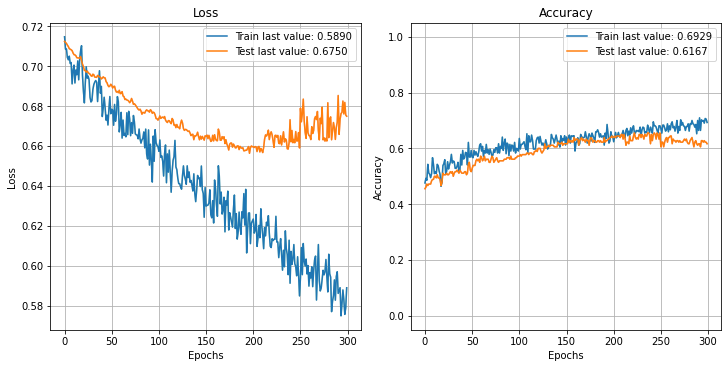

In [36]:
#Train the model
batch_size = 64

checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks_2/Practice module/checkpoint/checkpoint_cbow'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print('Train...')

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
hist_cbow = model_cbow.fit(text_train, y_train_onehot,
                           batch_size=batch_size,
                           epochs=300,
                           validation_data= (text_test, y_test_onehot), 
                           callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
model_cbow.load_weights(checkpoint_filepath)

loss, accuracy = model_cbow.evaluate(text_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_cbow.evaluate(text_test, y_test_onehot, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_cbow.history);

## LSTM (Skipgram)

In [37]:
# Prepare embedding matrix from Skipgram
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))

for word, i in word_index.items():
    embedding_vector = w2v_skipgram.get(word)
    if embedding_vector is not None:
        # words not found in w2v_skipgram will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

0.9484500174155347


In [38]:
#Define the BiLSTM model (using Skipgram)
##############################################
model_skipgram= Sequential()
model_skipgram.add(Embedding(vocab_size, 
                             embed_size, 
                             input_length = maxlen,
                             weights=[embedding_matrix],
                             trainable=False))
model_skipgram.add(Bidirectional(LSTM(64)))
#output Dropout
model_skipgram.add(Dropout(0.6))
model_skipgram.add(Dense(2, activation='softmax'))

# try using different optimizers and different optimizer configs
model_skipgram.compile('SGD', 'categorical_crossentropy', metrics=['accuracy'])
model_skipgram.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          287100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 371,838
Trainable params: 84,738
Non-trainable params: 287,100
_________________________________________________________________


Train...
Epoch 1/300
7/7 [==============================] - 5s 224ms/step - loss: 0.6887 - accuracy: 0.5190 - val_loss: 0.7024 - val_accuracy: 0.4333
Epoch 2/300
7/7 [==============================] - 0s 67ms/step - loss: 0.6905 - accuracy: 0.5119 - val_loss: 0.7027 - val_accuracy: 0.4500
Epoch 3/300
7/7 [==============================] - 0s 57ms/step - loss: 0.6892 - accuracy: 0.5381 - val_loss: 0.7029 - val_accuracy: 0.4389
Epoch 4/300
7/7 [==============================] - 0s 58ms/step - loss: 0.6912 - accuracy: 0.5143 - val_loss: 0.7032 - val_accuracy: 0.4500
Epoch 5/300
7/7 [==============================] - 0s 57ms/step - loss: 0.6872 - accuracy: 0.5357 - val_loss: 0.7033 - val_accuracy: 0.4500
Epoch 6/300
7/7 [==============================] - 0s 66ms/step - loss: 0.6969 - accuracy: 0.4833 - val_loss: 0.7036 - val_accuracy: 0.4722
Epoch 7/300
7/7 [==============================] - 0s 70ms/step - loss: 0.6908 - accuracy: 0.5024 - val_loss: 0.7035 - val_accuracy: 0.4778
Epoch 8/30

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f57d791de10>,
       dtype=object))

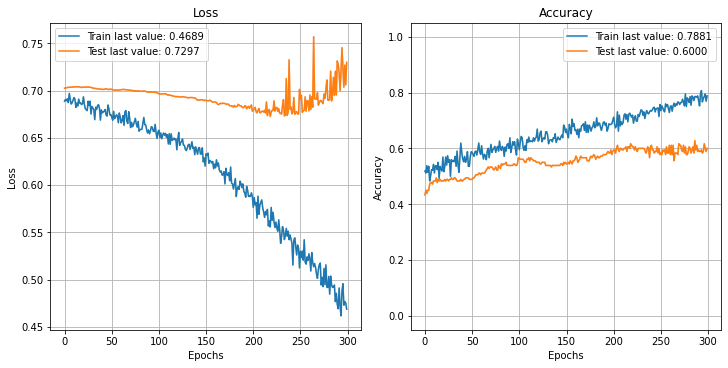

In [39]:
#Train the model
batch_size = 64

checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks_2/Practice module/checkpoint/checkpoint_skipgram'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print('Train...')

hist_skipgram = model_skipgram.fit(text_train, y_train_onehot,
                                   batch_size=batch_size,
                                   epochs=300,
                                   validation_data=(text_test, y_test_onehot), 
                           callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
model_skipgram.load_weights(checkpoint_filepath)

loss, accuracy = model_skipgram.evaluate(text_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_skipgram.evaluate(text_test, y_test_onehot, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_skipgram)

## LSTM (GLOVE)

In [40]:
# Prepare embedding matrix from GLOVE
embedding_matrix = np.zeros((len(word_index)+1, embed_size))

for word, i in word_index.items():
    embedding_vector = glove_twitter.get(word)
    if embedding_vector is not None:
        # words not found in glove_twitter will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

0.8460466736328806


In [41]:
#Define the BiLSTM model with dropout (using GLOVE)
##############################################
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 
                          embed_size, 
                          input_length=maxlen, 
                          weights=[embedding_matrix],
                          trainable=False))
model_glove.add(Bidirectional(LSTM(64)))
#output Dropout
model_glove.add(Dropout(0.6))
model_glove.add(Dense(2, activation='softmax'))

# try using different optimizers and different optimizer configs
model_glove.compile('SGD', 'categorical_crossentropy', metrics=['accuracy'])
model_glove.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          287100    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 371,838
Trainable params: 84,738
Non-trainable params: 287,100
_________________________________________________________________


Train...
Epoch 1/300
7/7 [==============================] - 5s 220ms/step - loss: 0.7466 - accuracy: 0.4714 - val_loss: 0.7092 - val_accuracy: 0.4333
Epoch 2/300
7/7 [==============================] - 0s 56ms/step - loss: 0.7295 - accuracy: 0.4643 - val_loss: 0.7099 - val_accuracy: 0.4111
Epoch 3/300
7/7 [==============================] - 0s 57ms/step - loss: 0.7395 - accuracy: 0.4500 - val_loss: 0.7093 - val_accuracy: 0.4167
Epoch 4/300
7/7 [==============================] - 0s 57ms/step - loss: 0.7228 - accuracy: 0.4810 - val_loss: 0.7080 - val_accuracy: 0.4111
Epoch 5/300
7/7 [==============================] - 0s 58ms/step - loss: 0.7029 - accuracy: 0.5429 - val_loss: 0.7110 - val_accuracy: 0.4333
Epoch 6/300
7/7 [==============================] - 0s 58ms/step - loss: 0.7108 - accuracy: 0.5071 - val_loss: 0.7083 - val_accuracy: 0.4167
Epoch 7/300
7/7 [==============================] - 0s 57ms/step - loss: 0.7098 - accuracy: 0.5214 - val_loss: 0.7099 - val_accuracy: 0.4333
Epoch 8/30

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5724224e10>,
       dtype=object))

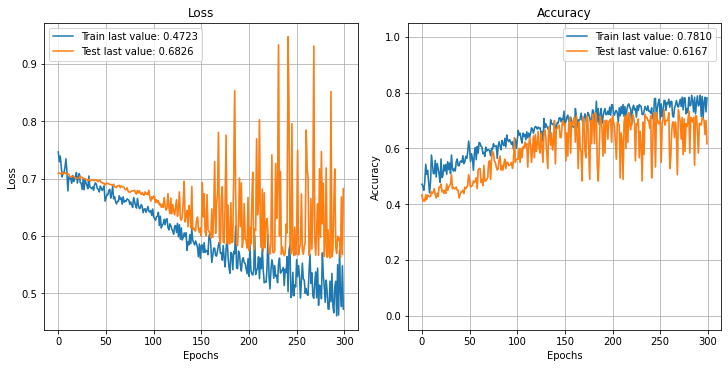

In [42]:
#Train the model
batch_size = 64

checkpoint_filepath = '/content/gdrive/My Drive/Colab Notebooks_2/Practice module/checkpoint/checkpoint_glove'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print('Train...')
hist_glove = model_glove.fit(text_train, y_train_onehot,
                             batch_size=batch_size,
                             epochs=300,
                             validation_data=(text_test, y_test_onehot), 
                             callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
model_glove.load_weights(checkpoint_filepath)

loss, accuracy = model_glove.evaluate(text_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_glove.evaluate(text_test, y_test_onehot, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_glove)

# Load LSTM models

In [96]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [43]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
text_train = tokenizer.texts_to_sequences(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embed_size = 100
maxlen = 100

def embedding_matrix(word_index, w2v):
    matrix = np.zeros((len(word_index) + 1, 100))

    for word, i in word_index.items():
        embedding_vector = w2v.get(word)
        if embedding_vector is not None:
            # words not found in w2v_cbow will be all-zeros.
            matrix[i] = embedding_vector
    
    return matrix


def BiLSTM_model(embedding_matrix):
    model = Sequential()
    model.add(Embedding(vocab_size, 
                        embed_size, 
                        input_length=maxlen,
                        weights=[embedding_matrix],
                        trainable=False))
    #model_cbow.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    #output Dropout
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    return model

In [44]:
# Glove token embedding
w2v_glove_PATH = "/content/gdrive/MyDrive/Practice module NLP/PLP Practice Module/glove.twitter.27B.100d.txt"
w2v_cbow_PATH = "/content/gdrive/MyDrive/Practice module NLP/PLP Practice Module/Cbow_vectors.txt"
w2v_skipgram_PATH = "/content/gdrive/MyDrive/Practice module NLP/PLP Practice Module/skipgram_vectors.txt"

encoding="utf-8"

with open(w2v_glove_PATH, "rb") as lines:
    wvec_glove = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}
    
with open(w2v_cbow_PATH, "rb") as lines:
    wvec_cbow = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

with open(w2v_skipgram_PATH, "rb") as lines:
    wvec_skipgram = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# def SentenceEmbed(word2vec):
#     return np.mean(list(word2vec.values()), axis = 0)

In [45]:
glove_embed = embedding_matrix(word_index, wvec_glove)
cbow_embed = embedding_matrix(word_index, wvec_cbow)
skipgram_embed = embedding_matrix(word_index, wvec_skipgram)

model_cbow = BiLSTM_model(cbow_embed)
model_skipgram = BiLSTM_model(skipgram_embed)
model_glove = BiLSTM_model(glove_embed)

model_cbow.load_weights('/content/gdrive/MyDrive/Practice module NLP/PLP Practice Module/checkpoint/checkpoint_cbow')
model_skipgram.load_weights('/content/gdrive/MyDrive/Practice module NLP/PLP Practice Module/checkpoint/checkpoint_skipgram')
model_glove.load_weights('/content/gdrive/MyDrive/Practice module NLP/PLP Practice Module/checkpoint/checkpoint_glove')

In [48]:
userinput = input('Enter text: ')
text = tokenizer.texts_to_sequences([userinput])
text_test = pad_sequences(text, maxlen = maxlen, padding = 'post')
print(np.argmax(model_cbow.predict(text_test)))
print(np.argmax(model_skipgram.predict(text_test)))
print(np.argmax(model_glove.predict(text_test)))

Enter text: horrible wait at the clinic
0
0
0
